In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.basemap import Basemap, cm
import pyowm
import time
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, RationalQuadratic, ConstantKernel as C
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
import CustomKernels
from CustomDistances import sq_distance, hv_distance
from matplotlib.patches import Path, PathPatch
from pyearth import Earth
import CustomModels
from sklearn.model_selection import train_test_split


##Formatting functions
def format_for_learning(xlat, xlon, temp):
    X = np.column_stack((xlat, xlon))
    Y = np.asarray(temp).reshape(len(temp),1)
    return X, Y

def format_grid_for_prediction(ylat, ylon):
    grid = np.column_stack((np.hstack((ylat)),np.hstack((ylon))))
    return grid
    
def format_prediction_to_grid(prediction, nrow, ncol):
    matrix = np.reshape(prediction, (nrow,ncol))  
    return matrix

    
##Nearest neighbor with plane euclidian distance
def NNI_temp(X, Y, grid):
    
    nsample = X.shape[0]
    npreds = grid.shape[0]
    prediction = np.empty(npreds)
    
    ##Vectorized operation is slower than for-loop
    #distance = hv_distance(grid[:,0,None], grid[:,1,None], X[:,0], X[:,1])
    #print(distance)
    #prediction = y[np.argmin(distance, axis=1)]
    
    for k in range(0, npreds):
        distance = hv_distance(grid[k][0], grid[k][1], X[:,0], X[:,1])
        prediction[k] = Y[np.argmin(distance)]
            
    return prediction
            
    
##Inverse distance weighting
##Param: radius of the IDW, if no points in the radius -> NNI 
def IDW_temp(X, Y, grid, radius):
    
    nsample = X.shape[0]
    npreds = grid.shape[0]
    prediction = np.empty(npreds)
    for k in range(0, npreds):
        numerator2 = 0
        denominator2 = 0
        distance = hv_distance(grid[k][0], grid[k][1], X[:,0], X[:,1])
        idx_in_radius = np.where(distance < radius)
        if idx_in_radius[0].size == 0:
            prediction[k] = Y[np.argmin(distance)]
        else:
            numerator = np.sum(Y[idx_in_radius]/distance[idx_in_radius])
            denominator = np.sum(1/distance[idx_in_radius])
            prediction[k] = numerator/denominator
            
    return prediction
        
        
def gaussprocess_temp(X, Y, grid):
    
    kernel = C(1.0)*RBF(length_scale=[10.0, 10.0]) + WhiteKernel(0.1)
    #gpr = GaussianProcessRegressor(kernel=kernel, alpha = 0, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=10, normalize_y=True, random_state=0).fit(X, y)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha = 0, optimizer=None, n_restarts_optimizer=10, normalize_y=True, random_state=0).fit(X, y)
    print("score: %f" % gpr.score(X, Y))
    preds = gpr.predict(grid)
    print(gpr.kernel_)
    
    return preds


def GWR_temp(X, Y, grid):
    
    kernel = C(1.0)*CustomKernels.RBF(length_scale_bounds=[10.0,1000.0], metric='haversine') + WhiteKernel(0.1)
    gwr = GaussianProcessRegressor(kernel=kernel, alpha = 0, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=10, normalize_y=True, random_state=0).fit(X, y)
    #gwr = GaussianProcessRegressor(kernel=kernel, alpha = 0, optimizer=None, n_restarts_optimizer=0, normalize_y=True, random_state=0).fit(X, y)
    print("score: %f" % gwr.score(X, Y))
    preds = gwr.predict(grid)
    print(gwr.kernel_)
    
    return preds
    

def regressiontree_temp(X, Y, grid, max_depth):
    
    rtree = DecisionTreeRegressor(max_depth=max_depth).fit(X, Y)
    preds = rtree.predict(grid)
    
    return preds


def randomforest_temp(X, Y, grid, max_ntree, max_depth, random_state):
    
    rforest = RandomForestRegressor(n_estimators=max_ntree, max_features='auto', 
                                    max_depth=max_depth, random_state=random_state).fit(X, Y)
    preds = rforest.predict(grid)
    
    return preds


def extratrees_temp(X, Y, grid, max_ntree, max_depth, random_state):
    
    extrees = ExtraTreesRegressor(n_estimators=max_ntree, max_features='auto', 
                                    max_depth=max_depth, random_state=random_state).fit(X, Y)
    preds = extrees.predict(grid)
    
    return preds


def SVR_temp(X, Y, grid):
    
    svr = SVR(gamma='auto', C=10.0, epsilon=5.0).fit(X, Y)
    preds = svr.predict(grid)
    
    return preds


def regressionsplines_temp(X, Y, grid, max_degree, penalty):
    
    splin = Earth(max_degree = max_degree, penalty = penalty).fit(X, Y)
    preds = splin.predict(grid)
    
    return preds


In [2]:
##Read cities list
obs = pd.read_csv("data/current-version/Temp-2019_01_04-15_47.csv", ',')
obs = obs.drop(['Unnamed: 0'], axis=1)

##Get cities coordinates and ID
nam = obs['City'].tolist()
lon = obs['Lon'].tolist()
lat = obs['Lat'].tolist()
ids = obs['ID'].tolist()
temps = obs['Temp'].tolist()

In [3]:
##Map boundaries
lon_min = -15.56
lat_min = 24.65
lon_max = 49.88
lat_max = 79.17

##Create map
map = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max, resolution = 'l', epsg=4668)

##Interpolation resolution
nx = 100
ny = 100

glons, glats = map.makegrid(nx, ny)
gx, gy = map(glons, glats)

##Format data for interpolation
X_learn, y_learn = format_for_learning(lat, lon, temps)
grid = format_grid_for_prediction(glats, glons)

##Partition data between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_learn, y_learn, test_size=0.2, random_state=42)
print("Number of train samples: " + str(X_train.shape[0]))
print("Number of test samples: " + str(X_test.shape[0]))

tic = time.time()
##Choose the interpolation model
model = CustomModels.NearestNeighbor()
score_train = model.train(X_train, y_train, eval_score=True)
print("Train score: " + str(score_train))
preds, score_test = model.predict(X_test, y_test, eval_score=True)
print("Test score: " + str(score_test))
#preds = NNI_temp(X_learn, y_learn, grid)
#preds = IDW_temp(X_learn, y_learn, grid, 500)
#preds = gaussprocess_temp(X_learn, y_learn, grid)
#preds = GWR_temp(X_learn, y_learn, grid)
#preds = regressiontree_temp(X_learn, y_learn, grid, 10)
#preds = randomforest_temp(X_learn, y_learn, grid, max_ntree=1000, max_depth=10, random_state=69)
#preds = extratrees_temp(X_learn, y_learn, grid, max_ntree=1000, max_depth=10, random_state=69)
#preds = SVR_temp(X_learn, y_learn, grid)
#preds = regressionsplines_temp(X_learn, y_learn, grid, 3, 1.0)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

##Format the predictions for plotting
preds = model.predict(grid)
predict = format_prediction_to_grid(preds, nx, ny)


Number of train samples: 754
Number of test samples: 189
Train score: 0.0
Test score: 7.74057460317
Time: 62.9999637604ms


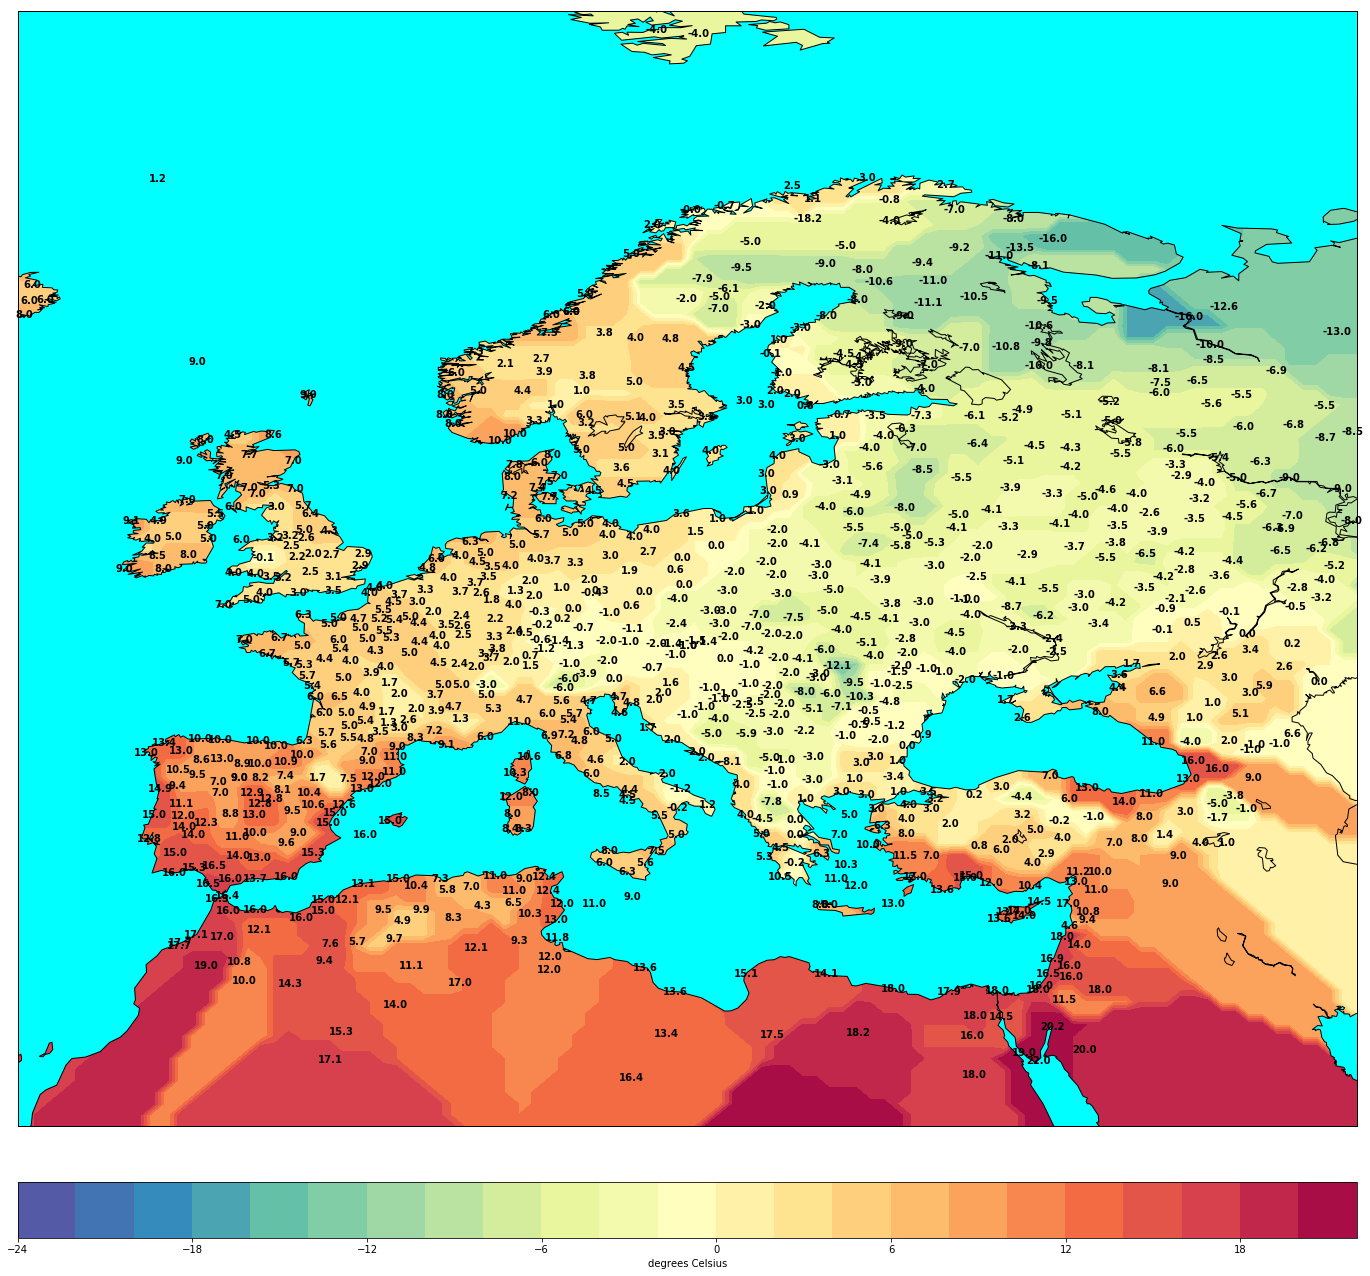

In [4]:
fig, ax = plt.subplots(figsize=(24,24))

map.drawmapboundary(fill_color='white')
#map.fillcontinents(color='coral',lake_color='white')
map.drawcoastlines()

x, y = map(lon, lat)
cities_out_bounds = []

##Create annotations for temperature and only keep cities in bound
for i in range(0,len(x)-1):
    if lon[i] > lon_min and lon[i] < lon_max and lat[i] > lat_min and lat[i] < lat_max:
        plt.text(x[i], y[i], "{0:.1f}".format(temps[i]),fontsize=10,fontweight='bold', ha='center',va='center',color='k')
    else:
        cities_out_bounds.append(nam[i])

##Plot contours
clevs = [-24,-22,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22]
cs = map.contourf(gx,gy,predict,clevs,cmap='Spectral_r')

##Display colorbar
cbar = map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('degrees Celsius')

##Getting the limits of the map:
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])

##Getting all polygons used to draw the coastlines of the map
polys = [p.boundary for p in map.landpolygons]

##Combining with map edges
polys = [map_edges]+polys[:]

##Creating a PathPatch
codes = [
    [Path.MOVETO] + [Path.LINETO for p in p[1:]]
    for p in polys
]
polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]
path = Path(polys_lin, codes_lin)
patch = PathPatch(path,facecolor='cyan',lw=0)

##Masking the data:
ax.add_patch(patch)

plt.show()

In [5]:
tic = time.time()
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

Time: 0.999927520752ms


In [6]:
X_train.shape[0]

754L

In [7]:
y_train.shape[0]

754L